<img src="https://github.com/nicholasmetherall/digital-earth-pacific-macblue-activities/blob/main/attachments/images/DE_Pacific_banner.JPG?raw=true" width="900"/>

Figure 1.1.a. Jupyter environment + Python notebooks

# Digital Earth Pacific Notebook 1 prepare postcard and load data to csv

The objective of this notebook is to prepare a geomad postcard for your AOI (masking, scaling and loading additional band ratios and spectral indices) and sampling all the datasets into a csv based on your training data geodataframe.

In [1]:
# # This cell is for papermill parameters. DO NOT CHANGE THE VARIABLE NAMES.
# # Default values for manual execution (papermill will override these)
# input_geojson_path = None
# output_csv_path = None

## Step 1.1: Configure the environment

In [2]:
import os
from datetime import datetime
from shapely.geometry import Polygon
from shapely import box
from pyproj import CRS 
import folium
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio as rio
import xarray as xr
import rioxarray
from ipyleaflet import basemaps
from numpy.lib.stride_tricks import sliding_window_view
import pystac_client
from dask.distributed import Client as DaskClient
from odc.stac import load, configure_s3_access
import planetary_computer
from odc.stac import load
from pystac.client import Client
from skimage.feature import graycomatrix, graycoprops
# from utils import load_data, scale, calculate_band_indices, apply_mask, mask_land, mask_deeps, mask_surf, mask_elevation, all_masks, glcm_features, do_prediction
import matplotlib.pyplot as plt
from odc.algo import binary_dilation, mask_cleanup
from skimage.morphology import disk
from utils import load_data, scale, calculate_band_indices, apply_mask, mask_land, mask_deeps, mask_elevation, mask_surf, all_masks, glcm_features, do_prediction

In [3]:
# Reload scripts and imports
%load_ext autoreload
%autoreload 2

In [4]:
# Predefined variable for title and version

# Enter your initials
initials = "nm"

# Enter your site name
site = "serua_revise"

# Date
date = datetime.now()

# Make a clean version string
version = f"{initials}-{site}-{date.strftime('%d%m%Y')}"
print(version)

nm-serua_revise-20082025


In [5]:
gdfs = []
postcards_path = "training-data/"
file_extension: str = ".geojson"

for filename in os.listdir(postcards_path):
    file_path = os.path.join(postcards_path, filename)
    if os.path.isfile(file_path) and filename.endswith(file_extension):
    # try:
        gdf = gpd.read_file(file_path)
        gdfs.append(gdf)

In [6]:
for filename in os.listdir(postcards_path):
    file_path = os.path.join(postcards_path, filename)
    if os.path.isfile(file_path) and filename.endswith(file_extension):
        print(filename) # This line will print the name of each GeoJSON file
        # The rest of your code to read the file and append to gdfs
        # gdf = gpd.read_file(file_path)
        # gdfs.append(gdf)

print("\nFinished listing GeoJSON files.")

serua_revise_postcard.geojson
serua_postcard.geojson

Finished listing GeoJSON files.


## Step 1.2: Configure STAC access and search parameters

In [7]:
catalog = "https://stac.digitalearthpacific.org"
client = Client.open(catalog)

In [8]:
# filename = "nm-efate-27072025_postcard.geojson"

In [9]:
# training = gpd.read_file(f"training-data/{site}_postcard.geojson")
# training = training.to_crs("EPSG:4326")
# min_lon, min_lat, max_lon, max_lat = training.total_bounds

# bbox = [min_lon, min_lat, max_lon, max_lat]

In [10]:
# # Serua-Deuba
# bbox = [177.85649, -18.30487, 178.01041, -18.25023]

# # Coral coast
# bbox = [177.50076, -18.23336, 177.85369, -18.18450]

# # North Viti Levu
# bbox = [177.4755, -17.5305, 178.3384, -17.1883]

# # Ba Estuary
# bbox = [177.4755, -17.5305,  177.71596, -17.31072,]

# # Suva
# bbox = [178.33211, -18.19602, 178.55566, -18.09947]

# # South Efate
# bbox = [168.24347, -17.81064, 168.39286, -17.72472]

# Suva
bbox = [178.410921, -18.188382, 178.46952, -18.14731]

In [11]:
datetime = "2024"

items = client.search(
    collections=["dep_s2_geomad"],
    datetime=datetime,
    bbox=bbox
).item_collection()

print(f"Found {len(items)} items in for {datetime}")

Found 1 items in for 2024


In [12]:
measurements = ["nir", "red", "blue", "green", "emad", "smad", "bcmad", "green", "nir08", "nir09", "swir16", "swir22", "coastal", "rededge1", "rededge2", "rededge3"]
data = load_data(
    items,
    measurements,
    bbox,
)
    
# Now you can use the 'data' variable
print(data)

<xarray.Dataset> Size: 11MB
Dimensions:      (y: 479, x: 654, time: 1)
Coordinates:
  * y            (y) float64 4kB -2.041e+06 -2.042e+06 ... -2.046e+06 -2.046e+06
  * x            (x) float64 5kB 3.163e+06 3.163e+06 ... 3.169e+06 3.169e+06
    spatial_ref  int32 4B 3832
  * time         (time) datetime64[ns] 8B 2024-01-01
Data variables: (12/15)
    nir          (time, y, x) uint16 627kB dask.array<chunksize=(1, 479, 654), meta=np.ndarray>
    red          (time, y, x) uint16 627kB dask.array<chunksize=(1, 479, 654), meta=np.ndarray>
    blue         (time, y, x) uint16 627kB dask.array<chunksize=(1, 479, 654), meta=np.ndarray>
    green        (time, y, x) uint16 627kB dask.array<chunksize=(1, 479, 654), meta=np.ndarray>
    emad         (time, y, x) float32 1MB dask.array<chunksize=(1, 479, 654), meta=np.ndarray>
    smad         (time, y, x) float32 1MB dask.array<chunksize=(1, 479, 654), meta=np.ndarray>
    ...           ...
    swir16       (time, y, x) uint16 627kB dask.array<

In [13]:
dask_client = DaskClient(n_workers=1, threads_per_worker=16, memory_limit='16GB')
configure_s3_access(cloud_defaults=True, requester_pays=True)

In [14]:
scaled = scale(data)
scaled = scaled.compute().squeeze()

In [15]:
# Explore the site we are working on
# scaled.odc.explore(vmin=0, vmax=0.3, bands=["red", "green", "blue"], crs="EPSG:3832", name=site)

In [16]:
scaled

<xarray.Dataset> Size: 34MB
Dimensions:      (y: 479, x: 654)
Coordinates:
  * y            (y) float64 4kB -2.041e+06 -2.042e+06 ... -2.046e+06 -2.046e+06
  * x            (x) float64 5kB 3.163e+06 3.163e+06 ... 3.169e+06 3.169e+06
    spatial_ref  int32 4B 3832
    time         datetime64[ns] 8B 2024-01-01
Data variables: (12/15)
    nir          (y, x) float64 3MB 0.0226 0.0234 0.0241 ... 0.0198 0.0198
    red          (y, x) float64 3MB 0.0282 0.0289 0.0302 ... 0.025 0.025 0.0251
    blue         (y, x) float64 3MB 0.0498 0.0512 0.0519 ... 0.0486 0.0493
    green        (y, x) float64 3MB 0.0453 0.0461 0.0471 ... 0.0381 0.0381
    emad         (y, x) float32 1MB 0.06151 0.06192 0.06632 ... 0.05972 0.05993
    smad         (y, x) float32 1MB 4.958e-06 4.793e-06 ... 4.81e-06 5.005e-06
    ...           ...
    swir16       (y, x) float64 3MB 0.0212 0.0212 0.0222 ... 0.0168 0.0167
    swir22       (y, x) float64 3MB 0.0206 0.0206 0.0214 ... 0.015 0.0148 0.0147
    coastal      (y, x) float64 3MB 0.0545 0.0546 0.0569 ... 0.0537 0.0535 0.053
    rededge1     (y, x) float64 3MB 0.0292 0.0293 0.0312 ... 0.0247 0.0246
    rededge2     (y, x) float64 3MB 0.0254 0.0255 0.0267 ... 0.0214 0.0213
    rededge3     (y, x) float64 3MB 0.0263 0.0264 0.0275 ... 0.0217 0.0217

In [17]:
scaled = calculate_band_indices(scaled)
Dataset = scaled

### GLCM texture analysis

The objective of this notebook was to train the machine learning model that will allow us to classify an area with land cover classes defined through the training data.

Step 1.2. Input the training data to sample geomad data from the postcard

In [18]:
# WINDOW_SIZE = 9
# LEVELS = 32

# # Input
# max = scaled.blue.max().values
# min = scaled.blue.min().values
# # Scale to 0-LEVELS for GLCM
# img = ((scaled.blue - min) / (max - min) * (LEVELS - 1)).clip(0, LEVELS - 1).values.astype(np.uint8)

# # Extract overlapping windows
# patches = sliding_window_view(img, (WINDOW_SIZE, WINDOW_SIZE))
# # Shape: (rows, cols, win_y, win_x)


In [19]:
# import numpy as np # Ensure numpy is imported if not already

# # Assuming 'patches' is a 4D NumPy array with dimensions (y_coords, x_coords, window_y_size, window_x_size)
# # To get the first patch (at y=0, x=0), you would index it like this:
# sample_patch_data = patches[0, 0, :, :]

# # Verify the shape of the extracted sample patch data
# print(f"Shape of sample_patch_data: {sample_patch_data.shape}")

# # Call glcm_features directly on this 2D sample data
# sample_result = glcm_features(sample_patch_data)

# # Print the shape of the result to get the number of features
# print(f"Shape of glcm_features output for a single patch: {sample_result.shape}")

In [20]:
# # Use apply_ufunc to vectorize over (row, col) dimensions
# result = xr.apply_ufunc(
#     glcm_features,
#     xr.DataArray(patches, dims=["y", "x", "win_y", "win_x"]),
#     input_core_dims=[["win_y", "win_x"]],
#     output_core_dims=[["feature"]],
#     vectorize=True,
#     dask="parallelized",
#     output_dtypes=[np.float32]
# )

# # Add coordinates & names
# pad = WINDOW_SIZE - 1
# result = result.assign_coords({
#     "y": scaled.y[: -pad],
#     "x": scaled.x[: -pad],
#     "feature": ["contrast", "homogeneity", "energy", "ASM", "correlation", "mean", "entropy"]
# })

# result_bands = result.to_dataset(dim="feature")

# # Combine with original
# combined = scaled.copy()
# combined = combined.assign(result_bands)

# combined

### Surf masking

Surf masks

In [21]:
combined = scaled
combined.odc.explore(vmin=0, vmax=0.3, bands=["red", "green", "blue"], crs="EPSG:3832", name=site)

In [22]:
swir_mask = (combined.swir16>0.08)
land_threshold=-0.02
land_mask = (combined.mndwi<land_threshold).squeeze()
swir_mask = swir_mask.astype(bool)
land_mask = land_mask.astype(bool)
land_mask = land_mask | swir_mask
water_mask = ~land_mask

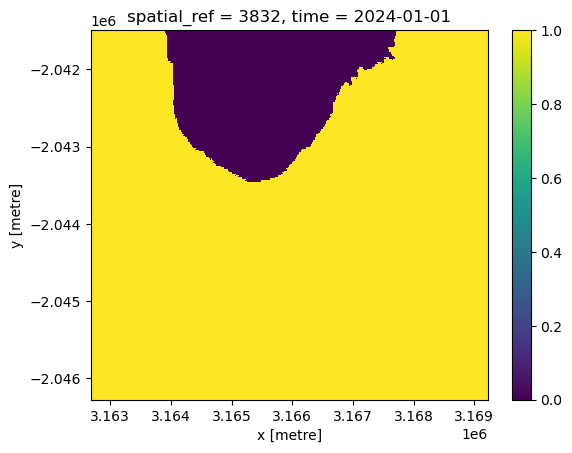

In [23]:
water_mask.plot()

In [24]:
surf_masked, mask = mask_surf(ds=combined, water_area_mask=water_mask, return_mask=True)

TypeError: mask_surf() got an unexpected keyword argument 'water_area_mask'

In [ ]:
# _, water_area_mask = mask_land(combined, return_mask=True)
water_mask = water_mask.chunk({'x': 512, 'y': 512}).astype(bool)


# Call mask_surf with return_mask=True
# It will return two values: the masked dataset AND the mask
surf_masked_dataset, final_surf_mask_for_keeping = mask_surf(
    ds=combined,
    water_area_mask=water_mask, # Pass your pre-computed water_area_mask
    return_mask=True, # <--- Set this to True
    # # You can also include other optional parameters here, like thresholds or radii
    # surf_blue_threshold=0.15,
    # surf_dilation_radius=40
)

final_surf_mask_for_keeping.plot()

In [ ]:
surf_masked.red.plot()

In [ ]:
swir_mask = (combined.swir16 < 0.06)

In [ ]:
swir_mask = (combined.swir16 > 0.08)

land_threshold = -0.2
land_mask = (combined.mndwi<land_threshold).squeeze()

swir_mask = swir_mask.astype(bool)
land_mask = land_mask.astype(bool)

land_mask = land_mask + swir_mask
# land_mask.plot()

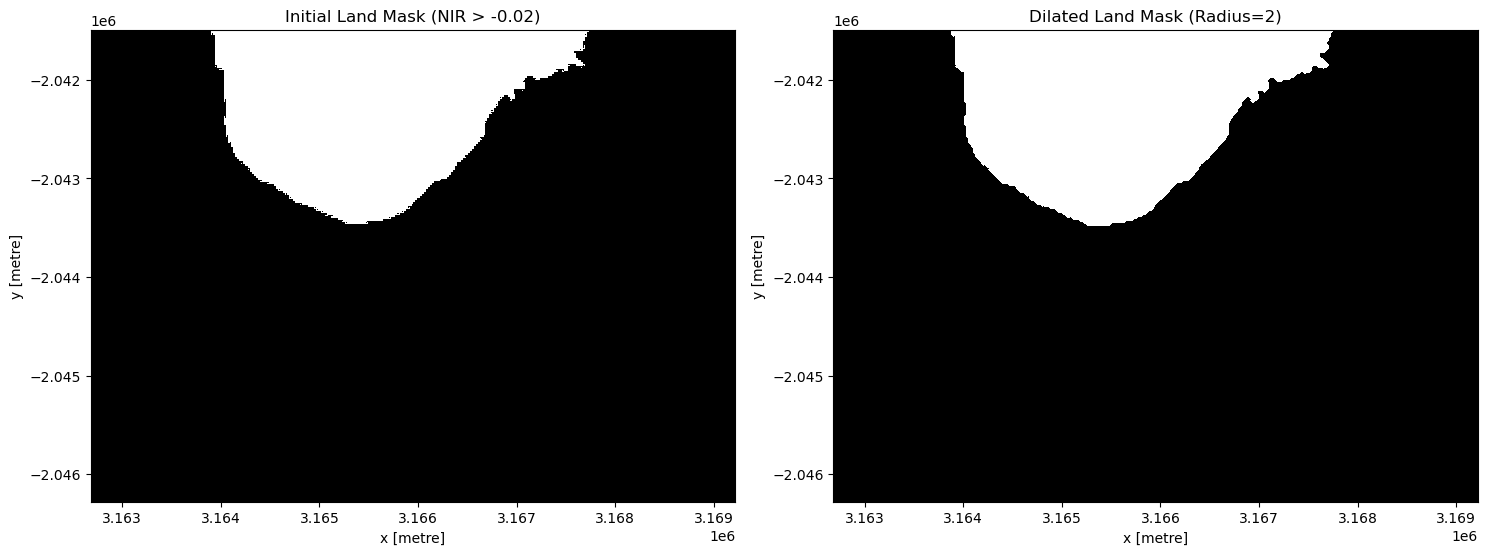

In [25]:
# land_mask = ~water_mask
land_mask = land_mask.chunk({'x': 512, 'y': 512})

land_mask = land_mask.astype(bool)
land_dilation_radius = 2


dilated_land_mask = binary_dilation(land_mask, radius=land_dilation_radius)

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Plot Initial Mask
land_mask.plot.imshow(
    ax=axes[0],
    cmap='gray', # 'gray' or 'Greys_r' are good for binary masks
    add_colorbar=False
)
axes[0].set_title(f'Initial Land Mask (NIR > {land_threshold})')
axes[0].set_aspect('equal', adjustable='box')


# Plot Dilated Mask
dilated_land_mask.plot.imshow(
    ax=axes[1],
    cmap='gray', # Use the same colormap for comparison
    add_colorbar=False,
)
axes[1].set_title(f'Dilated Land Mask (Radius={land_dilation_radius})')
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

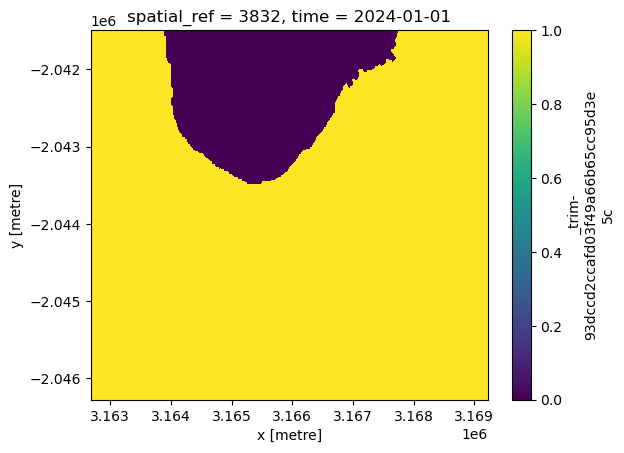

In [26]:

dilated_land_mask = dilated_land_mask.astype(bool)
# land_mask = land_mask.chunk({'x': 512, 'y': 512})

# land_mask = land_mask.astype(bool)
water_mask = ~dilated_land_mask
# water_mask = ~land_mask
water_mask.plot()


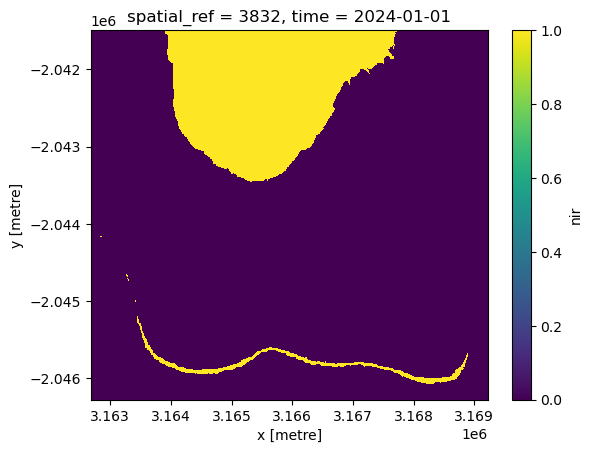

In [27]:

# from scipy.ndimage import binary_dilation
surf_threshold = 0.08

surf_mask = combined.nir > surf_threshold
# surf_mask = combined.nir.where(combined.nir<surf_threshold).squeeze()
# surf_mask = ~surf_mask
# surf_mask = combined.nir.where(surf_threshold)
surf_mask = surf_mask.astype(bool)

surf_mask.plot()

PosixPath('surf_combined.tif')

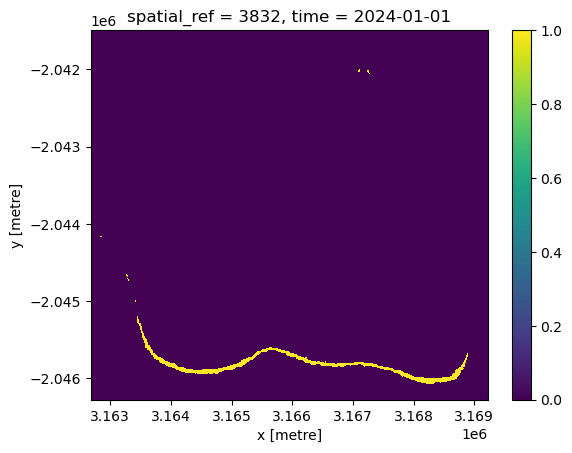

In [28]:
surf_mask = surf_mask & water_mask
surf_mask.plot()
surf_mask = surf_mask.astype('uint8')
surf_mask.odc.write_cog("surf_combined.tif", overwrite=True)

In [29]:
# In mask_surf function, within the refinement block:
# Define specific thresholds for each band (tune these values based on your imagery)
surf_blue_threshold = 0.27 # Example: Very high Blue reflectance
surf_green_threshold = 0.22 # Example: Very high Green reflectance
surf_red_threshold = 0.15   # Example: Very high Red reflectance
surf_nir_threshold = 0.08   # Example: Very high NIR reflectance

# The initial raw surf mask should now check multiple bands
initial_surf_mask_raw = (combined.blue > surf_blue_threshold) & \
                        (combined.green > surf_green_threshold) & \
                        (combined.red > surf_red_threshold) & \
                        (combined.nir > surf_nir_threshold)
# Then, this `initial_surf_mask_raw` is ANDed with `water_area_mask` as before.
initial_surf_mask_raw = initial_surf_mask_raw & water_mask
# initial_mask_for_dilation = mask_cleanup(surf_mask, [["erosion", 2], ["dilation", 2]])

# initial_surf_mask_raw.plot()


test_surf = initial_surf_mask_raw.astype('uint8')
# test_surf.odc.write_cog("test_surf.tif", overwrite=True)

In [30]:
test_surf.odc.explore(tiles=basemaps.Esri.WorldImagery)

/srv/conda/envs/notebook/lib/python3.10/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
/srv/conda/envs/notebook/lib/python3.10/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


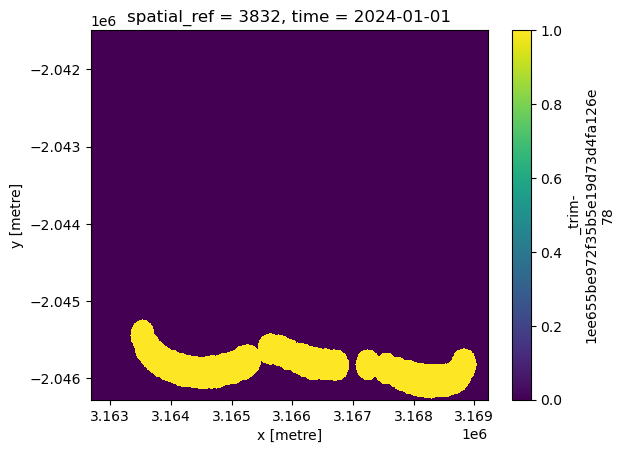

In [31]:
initial_mask_for_dilation = test_surf.astype(bool)
# initial_mask_for_dilation = mask_cleanup(initial_mask_for_dilation, [["erosion", 2], ["dilation", 2]])
# Then apply your main dilation_radius expansion:
expanded_mask = binary_dilation(initial_mask_for_dilation, radius=20)
expanded_mask.plot()

In [32]:
expanded_mask.odc.explore(tiles=basemaps.Esri.WorldImagery)

In [33]:
expanded_mask = expanded_mask.astype('uint8')
expanded_mask.odc.write_cog("expanded_combined.tif", overwrite=True)

PosixPath('expanded_combined.tif')

### Postcard csv

The objective of this notebook was to train the machine learning model that will allow us to classify an area with land cover classes defined through the training data.

Step 1.2. Input the training data to sample geomad data from the postcard

In [34]:
# Reproject training data to the GeoMAD CRS and convert to xarray
training_reprojected = training.to_crs(masked_combined.odc.crs)
training_da = training_reprojected.assign(
    x=training_reprojected.geometry.x, y=training_reprojected.geometry.y
).to_xarray()

# Extract training values from the masked dataset
training_values = (
    masked_combined.sel(training_da[["x", "y"]], method="nearest")
    .squeeze()
    .compute()
    .to_pandas()
)
training_values

NameError: name 'training' is not defined

In [ ]:
# Join the training data with the extracted values and remove unnecessary columns
training_array = pd.concat([training["cc_id"], training_values], axis=1)

# Drop rows where there was no data available
training_array = training_array.dropna()

# Preview our resulting training array
training_array.head()

In [ ]:
print(training_array.shape[1], 'total columns')
print('columns included', training_array.columns)

In [ ]:
standard_schema = ['cc_id', 'nir', 'red', 'blue', 'green', 'emad', 'smad', 'bcmad',
       'nir08', 'nir09', 'swir16', 'swir22', 'coastal', 'rededge1',
       'rededge2', 'rededge3', 'mndwi', 'ndti', 'cai', 'ndvi', 'evi', 'savi',
       'ndwi', 'b_g', 'b_r', 'mci', 'ndci', 'ln_bg', 'contrast', 'homogeneity',
       'energy', 'ASM', 'correlation', 'mean', 'entropy', 'y', 'x', 'time',
       'spatial_ref']

In [ ]:
training_array=training_array[standard_schema]

In [ ]:
training_array=training_array.drop(columns=["spatial_ref", "time"])

In [ ]:
# Write the training data to a CSV file
training_array.to_csv(f"training-data/csvs/{version}-training.csv", index=False)

In [ ]:
training_array["cc_id"].dtype